In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import scipy as sp

## Clustering Problem
Grouping data points into clusters, __without observed labels__. 

Samples within a cluster are similar to each other, and samples in different clusters are dissimilar. Such data forms a __multimodal__ distribution, as having multiple modes. 


## K-Means
Given data points $x^{(1)},...,x^{(N)}\in \mathbb R^D$, want to find cluster centers $\{m_k\}^K\in\mathbb R^D$ and assignments $\{r^{(n)}\}^N\in \mathbb R^K$ being 1-K encoding.  
 The objective is to minimize the cost as the squared sum distance of data points to their assigned centers, i.e. 
 $$\min_{\{m_k\},\{r^{(n)}\}}J(\{m_k\},\{r^{(n)}\}) = \min \sum^N\sum^K r^{(n)}\|m_k - x^{(n)}\|^2$$
Because $r$ works as an encoding, i.e. integer optimization problem, optimize both $r,m$ will be NP-hard. 

However, if we fix $m$, finding optimal assignments $r$ is easy, i.e. 
$$\min_{\{r^{(n)}\}}\sum^K r_k^{(n)}\|m_k-x^{(n)}\|^2\Rightarrow r_k = \mathbb I(k=\arg\min_k\|x^{(n)}-m_j\|^2)$$

If we fix $r$, then we can minimize by taking gradient and set to 0 
\begin{align*}
\partial_{m_l}\sum^N\sum^K r_k^{(n)}\|m_k - x^{(n)}\|^2 &= 0\\
2\sum^Nr_l^{(n)}(m_l - x^{(n)}) &= 0\\
m_l &= \frac{\sum^N r_l^{(n)}x^{(n)}}{\sum^Nr_l^{(n)}}
\end{align*}

Therefore, it is possible to do __alternating minimization__, i.e. minimize $J$ w.r.t. $m, k$ individually .

#### Algorithm
- Initialize with random cluster centers
- For each iterative step
  - Assignment step: assign data point to closest cluster by nearest neighbor
  - Refitting step: move each cluster center to the mean of the data assigned to it.

In [326]:
def kMeans(x, k, step, m=None):
    
    # initialization
    if m is None:
        m = x[np.random.choice(x.shape[0], k)]
    
    # iterative step
    for i in range(step):
        # assignment step
        kd = sp.spatial.KDTree(m)
        r = kd.query(x)[1]
        
        # refitting step
        for c in range(k):
            m[c] = x[r == c].mean(axis=0)
    return r, m

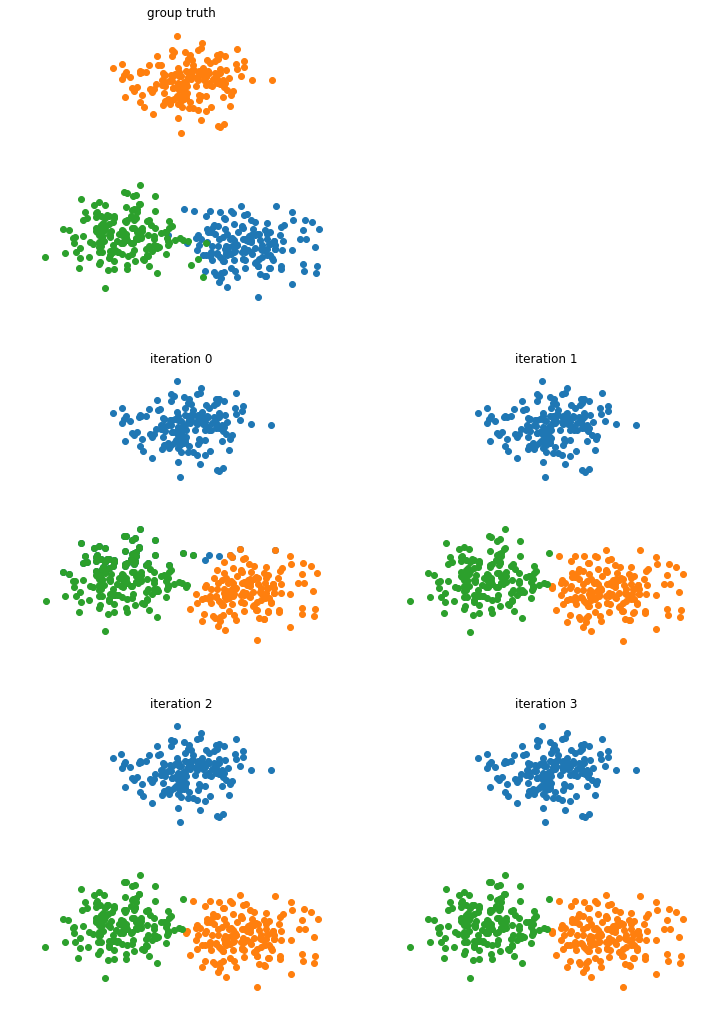

In [335]:
size = 3
centers = np.random.uniform(-5, 5, (size, 2))
sds = np.random.uniform(0.8, 1, size)

x, t = make_blobs(n_samples=500, centers=centers, n_features=2, cluster_std = sds, random_state=0)

plt.figure(figsize=(12, 18))
plt.subplot(321)
for i in range(size):
    plt.scatter(x[t==i, 0], x[t==i, 1])
plt.title("group truth")
plt.axis("off");

r, m = kMeans(x, 3, 1)
for iteration in range(4):
    plt.subplot(3, 2, 3 + iteration)
    plt.title("iteration " + str(iteration))
    plt.axis("off");
    for i in range(r.max() + 1):
        plt.scatter(x[r==i, 0], x[r==i, 1])
        r, m = kMeans(x, 3, 1, m)

#### Convergence 
Note that $J$ is lower bounded by 0 as a squared distance.  
Also, consider each assignment step, as $m$ fixed, for each $x^{(n)}$, $r_k^{(n)}$ guarantees $x^{(n)}-m_k$ is minimum.  
Consider each minimization step, as $r$ fixed, for each $\sum r_k( x^{(n)} - E(x^{(n)}))^2$ is minimized. 

Therefore, by monotone convergence theorem, this will converge.

However, this will not guarantee the global minimum. 

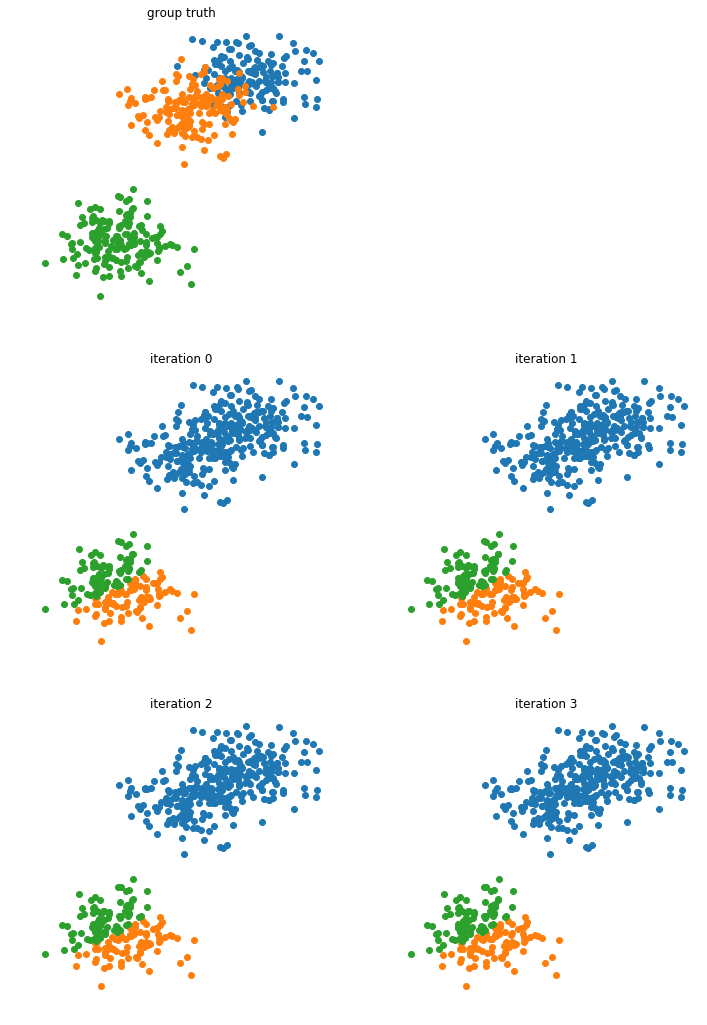

In [341]:
centers = np.array([[ 1.69653073,  4.85908807], [ 0.13447474,  3.7240316 ], [-2.02381919, -2.05536678]])
sds = 0.8119142178109643
m = np.array([[ 0.84192262,  4.26238333], [-1.67684624, -2.56679316], [-2.44040286, -1.48432092]])

x, t = make_blobs(n_samples=500, centers=centers, n_features=2, cluster_std = sds, random_state=0)

plt.figure(figsize=(12, 18))
plt.subplot(321)
for i in range(size):
    plt.scatter(x[t==i, 0], x[t==i, 1])
plt.title("group truth")
plt.axis("off");

r, m = kMeans(x, 3, 1, m)
for iteration in range(4):
    plt.subplot(3, 2, 3 + iteration)
    plt.title("iteration " + str(iteration))
    plt.axis("off");
    for i in range(r.max() + 1):
        plt.scatter(x[r==i, 0], x[r==i, 1])
        r, m = kMeans(x, 3, 1, m)

## Soft k-Means

Instead of making 0-1, we can make soft assignment, which we assign the clusters by responsibility (probability). 

#### Algorithm
 - Initialize $m$ random
 - Iterative step
   - Assignment
   $$r_k^{(n)} = \frac{\exp(-\beta\|m_k-x^{(n)}\|^2)}{\sum_j\exp (-\beta \|m_j-x^{(n)}\|^2)} = softmax(-\beta\{\|m_k-x^{(n)}\|^2\}^K)$$
   - Refitting
   $$m_k = \frac{\sum_n r_k^{(n)}x^{(n)}}{\sum_n r_k^{(n)}}$$
   
Note that 
\begin{align*}
\lim_{\beta\rightarrow \infty}r_k^{(n)}&= \lim_{\beta\rightarrow\infty}\frac{\exp(-\beta\|m_k-x^{(n)}\|^2)}{\sum_j\exp (-\beta \|m_j-x^{(n)}\|^2)}\\
&= \lim_{\beta\rightarrow\infty}\frac{\exp(-\beta\|m_k-x^{(n)}\|^2)}{\exp(-\beta\|m_k-x^{(n)}\|^2) + \sum_{j\neq k}\exp (-\beta \|m_j-x^{(n)}\|^2)}\\
&= \lim_{\beta \rightarrow \infty}\frac{1}{1+\sum_{j\neq k}\exp \bigg(-\beta (\|m_j-x^{(n)}\|^2 - \|m_k-x^{(n)}\|^2)\bigg)}&(*)\\
&= \mathbb I(k=\arg\min_k\|m_k-x^{(n)}\|^2)
\end{align*}
$(*)$ when $k$ is the argmin, then $d:=\|m_j-x^{(n)}\|^2 - \|m_k-x^{(n)}\|^2 > 0, -\beta d\rightarrow -\infty, \exp(-\beta d)\rightarrow 0$.  
Otherwise, exists some $d<0, \exp(-\beta d) \rightarrow \infty, \lim r^{(n)}_k = 0$

However, this raises questions about how to set $\beta$, and how to cluster unequal weight and width. 

#### Termination condition
We can test whether we can terminate the k-Mean's iterative steps by checking whether the assignment change. 

## Generative Model
Consider the generative model for $\mathcal D$:  
Assume data point $x$ is generated as
 - choose a cluster $z$ from $\pi = [\pi_1,...,\pi_K]^T, p(z=k)=\pi_k$
 - Given $z$, sample $x$ from $N(x|\mu_z, I)$
 $$p(z=k)=\pi_k, p(x|z=k)=N(x|\mu_k, I)$$
 
Then the joint distribution $p(z,x) = p(z)p(x|z)$ with parameters $\{\pi_k, \mu_k\}^K$,   marginal probability of $x, p(x)=\sum_zp(z,x)$  
the probability $x$ came from kth cluster is $p(z=k|x) = \frac{p(x|z=k)p(z=l)}{p(x)}$

#### Gaussian Mixture Model (GMM)
Using MLE approach, since we can't see the cluster assignments $z$, we only see $x$, i.e. the pbjective is 
\begin{align*}
p(\mathcal D) \Rightarrow \log(p(\mathcal D)) &= \sum^N \log(p(x^{(n)})) \\
&= \sum^N\sum^K p (z=k)p(x^{(n)}|z=k)\\
&= \sum^N\sum^K \pi_k N(x|\mu_k, I)
\end{align*}
Such distribution is an example of __Gaussian Mixture Model (GMM)__ and $\pi_k$ are the __mixing coefficients__. 

In general, each Gaussian will have different covariance, i.e. $N(x|\mu_k, \sigma_k)$. 

Note that $\log(p(\mathcal D)) = \sum^N\log \bigg(\sum^K \pi_k N(x^{(n)}| \mu_k, I)\bigg)$

Similar to k-Means, if we knew $z^{(n)}$, i.e. assignment, then the log likelihood is similar to a classification question, i.e. 
$$\log p(\mathcal D_{complete}) = \sum^N \log p(z^{(n)}, x^{(n)}) = \sum^N\sum^K \mathbb I(z^{(n)} = k)\bigg[\log(N(x^{(n)}|\mu_k, I) + \log\pi_k)\bigg]$$
The maximization results in 
$$\hat\mu_k = \frac{\sum^N \mathbb I(z^{(n)}=k)x^{(n)}}{\sum^N \mathbb I(z^{(n)}=k)} = \text{class mean}$$
$$\hat\pi_k = N^{-1}\sum^N \mathbb I(z^{(n)}=k) = \text{class proportions}$$

Then, we replace assignment since $E(z^{(n)}) = p(z=k|x)$ where $p(z=k|x)$ is computed from Bayes rule
\begin{align*}
p(z=k|x) &= \frac{p(z=k)p(x|z=k)}{p(x)}\\
&= \frac{p(z=k)p(x|z=k)}{\sum^K p(z=j)p(x|z=j)}\\
&= \frac{\pi_k N(x|\mu_k, I)}{\sum^K_j \pi_jN(x|\mu_k, I)}
\end{align*}

Therefore, let $r_k^{(n)} := p(z^{(n)}=k|x^{(n)})$ replace $\mathbb I(z^{(n)}=k)$, and 

$$\log p(\mathcal D_{complete}) = \sum^N \log p(z^{(n)}, x^{(n)}) = \sum^N\sum^K  r_k^{(n)}\bigg[\log(N(x^{(n)}|\mu_k, I) + \log\pi_k)\bigg]$$
The maximization results in 
$$\hat\mu_k = \frac{\sum^N r_k^{(n)} x^{(n)}}{\sum^N r_k^{(n)}} = \text{class mean}$$
$$\hat\pi_k = N^{-1}\sum^N r_k^{(n)} = \text{class proportions}$$

### Expectation Maximization Algorithm
- __E-step__ compute the posterior probabilities $r_k^{(n)} = p(z^{(n)}=k|x^{(n)})$ given our current model
- __M-step__ update $\mu, \pi$

#### Possible Problems 
 - Singularities: arbitrarily large likelihood when a Gaussian explains a single point with variance shrinking to zero
 - Non-convex